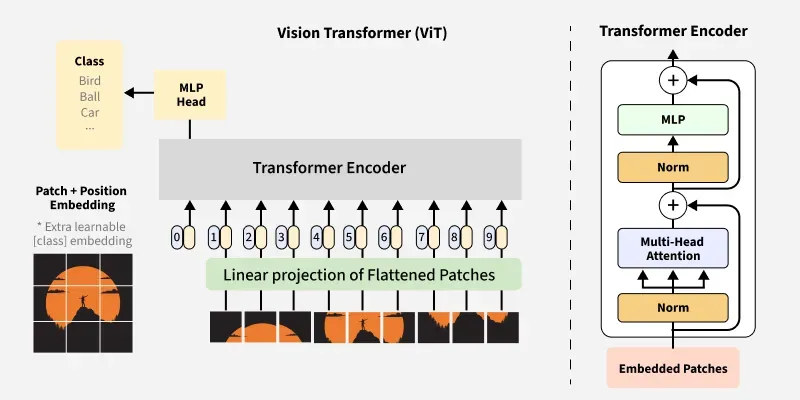

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

In [19]:
img_channels = 3
img_size = 64
patch_size = 64
embed_dim = 64
batch_size = 16
num_patches = 1
dropout = 0.0

In [111]:
def split_into_blocks(image, n_h, n_w):
    """
    Разделяет изображение на n_h × n_w блоков.

    Args:
        image (torch.Tensor): Тензор (C, H, W).
        n_h (int): Количество частей по высоте.
        n_w (int): Количество частей по ширине.

    Returns:
        torch.Tensor: Тензор (n_h * n_w, C, H//n_h, W//n_w).
    """
    c, h, w = image.shape
    block_h = h // n_h
    block_w = w // n_w

    # Разделение на блоки с помощью unfold
    blocks = image.unfold(1, block_h, block_h).unfold(2, block_w, block_w)
    blocks = blocks.contiguous().view(-1, c, block_h, block_w)

    return blocks

# Пример:
image = torch.randn(3, 256, 256)  # (C, H, W)
blocks = split_into_blocks(image, 4, 4)  # 4x4=16 блоков
print(blocks.shape)  # (16, 3, 64, 64)

torch.Size([16, 3, 64, 64])


In [110]:
def patches():
  patches = blocks.contiguous().view(batch_size, img_channels, -1, patch_size * patch_size)
  patches = patches.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, img_channels * patch_size * patch_size)
  # print("patches shape after flatten:", patches.shape)
  return patches

In [109]:
def lin_projection(img_channels,patch_size,embed_dim):
  projection = nn.Linear(img_channels * patch_size * patch_size, embed_dim)
  embedded_patches = projection(patches)
  #print("embedded_patches shape:", embedded_patches.shape)
  return embedded_patches

In [112]:
def cl_tok(embedded_patches):
  cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
  print(cls_token.shape)
  cls_tokens = cls_token.expand(batch_size, -1, -1)
  tokens = torch.cat([cls_tokens, embedded_patches], dim=1)
  print(tokens.shape)
  return tokens

In [113]:
def posit():
  pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))  # (1, N+1, D)

  # 6. Добавляем позиционные эмбеддинги
  tokens = tokens + pos_embedding  # (B, N+1, D)
  #print(tokens.shape)
  return tokens

In [114]:
import torch
import torch.nn as nn

class PatchEmbeddingWithCLS(nn.Module):
    """
    Изображение -> последовательность токенов (CLS + патчи) с позиционными эмбеддингами.

    Вход:  x (B, C, H, W)
    Выход: tokens (B, N+1, D), где N = (H/P)*(W/P)
    """
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        assert img_size % patch_size == 0, "img_size должно делиться на patch_size"
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # Кол-во патчей
        self.num_patches_h = img_size // patch_size
        self.num_patches_w = img_size // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        patch_dim = in_chans * patch_size * patch_size

        # Линейная проекция патчей
        self.proj = nn.Linear(patch_dim, embed_dim)

        # CLS-токен (обучаемый)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Позиционные эмбеддинги (обучаемые) для CLS + всех патчей
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

        # Инициализация
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.xavier_uniform_(self.proj.weight)
        if self.proj.bias is not None:
            nn.init.zeros_(self.proj.bias)

    def _img_to_patches(self, x):
        """
        Превращает (B, C, H, W) в (B, N, patch_dim), где patch_dim = C*P*P.
        """
        B, C, H, W = x.shape
        P = self.patch_size
        # (B, C, Nh, Nw, P, P)
        patches = x.unfold(2, P, P).unfold(3, P, P)
        # -> (B, C, Nh*Nw, P*P)
        patches = patches.contiguous().view(B, C, -1, P * P)
        # -> (B, Nh*Nw, C, P*P)
        patches = patches.permute(0, 2, 1, 3).contiguous()
        # -> (B, N, C*P*P)
        patches = patches.view(B, -1, C * P * P)
        return patches  # (B, N, patch_dim)

    def forward(self, x):
        """
        x: (B, C, H, W)
        return: (B, N+1, D)
        """
      #  B, C, H, W = x.shape
      #  assert H == self.img_size and W == self.img_size, "Размер входа должен совпадать с img_size при инициализации."

        # 1) Патчи -> (B, N, patch_dim)
      #  patches = self._img_to_patches(x)

        # 2) Линейная проекция -> (B, N, D)
        patch_embeddings = self.proj(x)

        # 3) CLS токен (распространяем на батч)
        cls_tokens = self.cls_token.expand(16, -1, -1)  # (B, 1, D)

        # 4) Конкатенация CLS + патчи
        tokens = torch.cat([cls_tokens, patch_embeddings], dim=1)  # (B, N+1, D)

        # 5) Добавляем позиционные эмбеддинги
        tokens = tokens + self.pos_embed  # broadcast (1, N+1, D) -> (B, N+1, D)

        return tokens


transformer encoder

In [115]:
class Feed_Forward(nn.Module):
    def __init__(self):
      super().__init__()
      self.net = nn.Sequential(
              nn.Linear(embed_dim, 4 * embed_dim),
              nn.ReLU(),
              nn.Linear(4 * embed_dim, embed_dim),
              nn.Dropout(dropout),
              )
    def forward(self,x):
      return self.net(x)


class MHA(nn.Module):
        def __init__(self):
            super().__init__()
            d_model=64
            num_heads=4
            self.d_model = d_model
            self.num_heads = num_heads
            self.d_k = d_model // num_heads

            self.W_Q = nn.Linear(d_model, d_model)
            self.W_K = nn.Linear(d_model, d_model)
            self.W_V = nn.Linear(d_model, d_model)
            self.W_A = nn.Linear(d_model, d_model)
        def forward(self,Q,K,V):
            Q = self.W_Q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
            K = self.W_K(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
            V = self.W_V(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

            scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
            weights = F.softmax(scores, dim=-1)
            output = torch.matmul(weights, V)

            output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
            return self.W_A(output)


class trans_encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.norm = nn.LayerNorm(embed_dim)
    self.mha = MHA()
    self.feed_forward = Feed_Forward()
  def forward(self,x):
    x1 = self.norm(x)
    x2 = self.mha(x1,x1,x1)
    x3 = x2 + x
    x4 = self.norm(x3)
    x5 = self.feed_forward(x4)
    x6 = x5 + x3
    return x6

all

In [116]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
"""class vision(nn.Module):
  def __init__(self):
    super().__init__()
    self.ssplit = split_into_blocks(4,4)
    self.patch = patches()
    self.proj = lin_projection()
    self.cls = cl_tok()
    self.pos = posit()
  def forward(self,x):
    x = self.ssplit(x,4,4)
    x2 = self.patch()
    x3 = self.proj()
    x4 = self.cls(x3)
    x5 = self.pos()
    return x5"""

In [117]:
class VIT(nn.Module):
  def __init__(self):
    super().__init__()
    self.trans = trans_encoder()
    self.pewc = PatchEmbeddingWithCLS(64,64,3,64)
    self.lin = nn.Linear(64,10)
  def forward(self,x):
    x = x[0]
    x1 = split_into_blocks(x,4,4)
    x2 = patches()
    x3 = self.pewc(x2)
    x4 = self.trans(x3)
    x5 = self.lin(x4)
    return x5

In [118]:

criterion = nn.CrossEntropyLoss()
model = VIT()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = 'cpu'

In [119]:


def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            logits = outputs[:, 0, :]
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')

    print('Finished Training')

train_model(model, criterion, optimizer, num_epochs=3)

Epoch [1/3], Loss: 2.3081
Epoch [2/3], Loss: 2.3049
Epoch [3/3], Loss: 2.3045
Finished Training


In [123]:


testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

In [124]:
classes = trainset.classes

def evaluate_model(model):
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            logits = outputs[:, 0, :]
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

evaluate_model(model)

Accuracy on the test set: 1.07%
